# Deducing transitions from equations

Deducing ODEs from transitions is as simple as adding up all the different flows in and out of each state.
In this process, information is lost regarding the nature (origin and destination) of the constituent transitions and so the reverse problem, deducing transitions from ODEs, is more difficult.
PyGOM includes some tools to attempt to distinguish the implied flows between compartments given a set of equations, but given that multiple underlying flow configurations can separately explain an ODE system, this functionality should be used with caution.
Here we demonstrate how this works in practice for two potentially tricky problems, the first of which is a system where the total population count is not conserved and the second is a system where a flow out of some of the compartments is split between multiple destinations.

## SIR with births and deaths

For our first example, let's consider the SIR model with standard incidence mixing and births and deaths proportional to the total population count, but not necessarily balanced:

$$\begin{aligned}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\frac{\beta SI}{N} + B N - \mu S \\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \frac{\beta SI}{N} - \gamma I - \mu I \\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma I - \mu R \\
\frac{\mathrm{d} N}{\mathrm{d} t} &= (B-\mu)N
\end{aligned}$$

Given that the infection rate, $\frac{\beta SI}{N}$, depends on the total population, it is necessary to keep track of $N(t)$ in the final equation. 
Here we encounter an issue when thinking in terms of compartments:
The total number of living individuals, $N$, is not a distinct category, rather, $S$, $I$ and $R$ are a subset of it.
Thus, whilst valid to define a system of ODEs as we have done above, PyGOM will run into difficulties as it will interpret $N$ as a compartment.
One solution could be to define $N$ as a time dependent parameter, however PyGOM does not currently have this functionality.

Instead, we must be careful to ensure that we only pass state equations to PyGOM's transition calculating function, {func}`.get_unrolled_obj()`.
The implication for the current example is that we eliminate the final equation and substitute $N=S+I+R$ everywhere else.

Let's set up the {class}`.SimulateOde` object as usual:

In [8]:
from pygom import SimulateOde, Transition, TransitionType

odeList = [
    Transition(transition_type=TransitionType.ODE, origin='S', equation='-beta*S*I/(S+I+R) + B*(S+I+R) - mu*S'),
    Transition(transition_type=TransitionType.ODE, origin='I', equation='beta*S*I/(S+I+R) - gamma*I - mu*I'),
    Transition(transition_type=TransitionType.ODE, origin='R', equation='gamma*I - mu*R') 
]

stateList = ['S', 'I', 'R']
paramList = ['beta', 'gamma', 'B', 'mu']

model = SimulateOde(state=stateList, param=paramList, ode=odeList)

If we now inspect the transition matrix:

In [9]:
model.get_StateChangeMatrix()

Matrix(3, 0, [])

we see that it is empty.
This is because {class}`.SimulateOde` was not initialized using transitions, but by ODEs.
We can populate the transition matrix by calling an algorithm to extract the flow information:

In [10]:
model = model.get_unrolled_obj()

Update: In the latest version, you should define births as having a destination state instead of an origin.
Update: In the latest version, you should define births as having a destination state instead of an origin.
Update: In the latest version, you should define births as having a destination state instead of an origin.
Update: In the latest version, between state transitions should be passed to SimulateODE via the Event objects.
Update: In the latest version, birth/death transitions should be passed to SimulateODE via the Event objects.


and can verify that the calculated transition matrix now matches what we would expect:

In [11]:
model.get_StateChangeMatrix()

Matrix([
[-1,  0, 1, -1, 1, 1,  0,  0],
[ 1, -1, 0,  0, 0, 0, -1,  0],
[ 0,  1, 0,  0, 0, 0,  0, -1]])

In [12]:
model.get_EventRateVector()

Matrix([
[I*S*beta/(I + R + S)],
[             I*gamma],
[                 B*S],
[                S*mu],
[                 B*R],
[                 B*I],
[                I*mu],
[                R*mu]])

Birth and death processes are not between states, rather into and out of the system and so do not appear in the transition matrix.
We could always get around this by defining another class (perhaps **U**nliving) as a limitless reservoir where births may come from and deaths may flow into.
Alternatively, we can view the birth and death processes by inspecting a graph of the transitions.

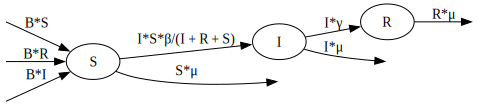

In [13]:
graph=model.get_transition_graph(show=False)
graph

## SLIAR epidemic model

Now we turn to a problem that does not have a one to one mapping between all the transitions and the terms in the ODEs.
In this model, **S**usceptible individuals may be infected and enter a **L**atent phase.
The rate at which individuals leave this state is $\kappa$, after which a fraction, $p$, become **I**nfective and the remaining, $(1-p)$, become **A**symptomatic.
Both these classes are capable of onward transmission, however, those in the **A** class have infectivity reduced by a factor $\delta$ relative to the **I** class.
All **A**symptomatics eventually become **R**emoved at a rate $\eta$, whereas a fraction, $f$, of the infectives recover, the remaining $(1-f)$ going on to die (both at a rate $\alpha$).

The equations are as follows:

$$\begin{aligned}
\frac{\mathrm{d}S}{\mathrm{d}t} &= -\beta S (I + \delta A) \\    
\frac{\mathrm{d}L}{\mathrm{d}t} &= \beta S (I + \delta A) - \kappa L \\  
\frac{\mathrm{d}I}{\mathrm{d}t} &= p \kappa L - \alpha I \\
\frac{\mathrm{d}A}{\mathrm{d}t} &= (1 - p) \kappa L - \eta A \\
\frac{\mathrm{d}R}{\mathrm{d}t} &= f \alpha I + \eta A \\
\end{aligned}$$

In this case, the potential difficulty comes from the outflows of state **L** and **I**.
For **L**, this is composed of two transitions, one to **I** and the other to **A** but the ODE of **L** only reflects the total flow going out of the state.
Similarly for **I**, the outflow, $\alpha I$, is partitioned as $f \alpha I$ into state **R** with the rest assumed dead, though not explicitly stated in the equations.

We set up the {class}`.SimulateOde` object for this case:

In [14]:
from pygom import SimulateOde, Transition, TransitionType

stateList = ['S', 'L', 'I', 'A', 'R']
paramList = ['beta', 'p', 'kappa', 'alpha', 'f', 'delta', 'eta']
odeList = [Transition(origin='S', equation='- beta*S*(I + delta*A)', transition_type=TransitionType.ODE), 
           Transition(origin='L', equation='beta*S*(I + delta*A) - kappa*L', transition_type=TransitionType.ODE),
           Transition(origin='I', equation='p*kappa*L - alpha*I', transition_type=TransitionType.ODE),
           Transition(origin='A', equation='(1 - p)*kappa*L - eta*A', transition_type=TransitionType.ODE),
           Transition(origin='R', equation='f*alpha*I + eta*A', transition_type=TransitionType.ODE)]
model = SimulateOde(stateList, paramList, ode=odeList)

Deducing the transitions and inspecting the resulting transition graph:

Update: In the latest version, you should define births as having a destination state instead of an origin.
Update: In the latest version, between state transitions should be passed to SimulateODE via the Event objects.
Update: In the latest version, birth/death transitions should be passed to SimulateODE via the Event objects.


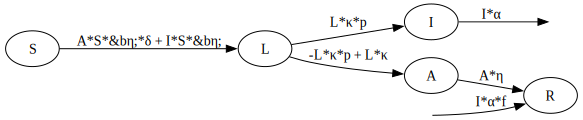

In [15]:
model = model.get_unrolled_obj()
graph=model.get_transition_graph(show=False)
graph

We notice that the **L** outflow has been captured, but the outflow from **I** is assumed to be a full death process of which a fraction are born into the recovered state.
This appearance of an incorrect, but still consistent, configuration demonstrates the difficulty in performing such reverse engineering.
One work-around is if we explicitly introduce a dead state, $D$:

Update: In the latest version, between state transitions should be passed to SimulateODE via the Event objects.


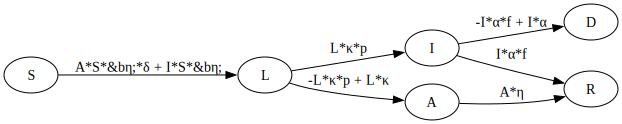

In [16]:
stateList = ['S', 'L', 'I', 'A', 'R', 'D']
paramList = ['beta', 'p', 'kappa', 'alpha', 'f', 'delta', 'eta']
odeList = [Transition(origin='S', equation='- beta*S*(I + delta*A)', transition_type=TransitionType.ODE), 
           Transition(origin='L', equation='beta*S*(I + delta*A) - kappa*L', transition_type=TransitionType.ODE),
           Transition(origin='I', equation='p*kappa*L - alpha*I', transition_type=TransitionType.ODE),
           Transition(origin='A', equation='(1 - p)*kappa*L - eta*A', transition_type=TransitionType.ODE),
           Transition(origin='R', equation='f*alpha*I + eta*A', transition_type=TransitionType.ODE),
           Transition(origin='D', equation='(1-f)*alpha*I', transition_type=TransitionType.ODE)]
model = SimulateOde(stateList, paramList, ode=odeList)
model = model.get_unrolled_obj()
graph=model.get_transition_graph(show=False)
graph